# Connect to google drive

In [1]:
import os
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import random
import pandas as pd
import numpy as np
from PIL import Image
import urllib
import glob
import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import easydict
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix

random.seed(777)
np.random.seed(777)
torch.manual_seed(777)
torch.cuda.manual_seed(777)

# Setting Hyperparameters

In [2]:
args = easydict.EasyDict({
    'name': 'ResNet_useall', #model name
    'train': True,
    'batch_size': 256,       # input batch size
    'n_epochs': 200,         # number of epochs
    'n_workers': 4,         # number of data loading workers
    'optimizer': 'adam', #optimizer (adam or sgd)
    'learning_rate': 0.002, # learning rate
    'beta1': 0.9,           # beta 1 for adam
    'beta2': 0.999,         # beta 2 for adam
    'momentum': 0.9,        # momentum for SGD
    'weight_decay': 5e-4,   # weight_decay for SGD
    'step_size': 25,        # step size
    'gamma': 0.8,           # gamma
    'in_data_file': 'data/', # data directory
    'model': '',      # model path reload
    'out_dir': 'outputs/'    # output directory
})

In [3]:
train_path = "./data/train_images"
files = glob.glob(f"{train_path}/*.jpg")
csv = './data/train.csv'
csv = pd.read_csv(csv)
train_ratio = 0.8

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


**Outliers**

In [4]:
unusual = [
    '1004389140.jpg',
    '1008244905.jpg',
    '1338159402.jpg',
    '1339403533.jpg',
    '159654644.jpg',    
    '1010470173.jpg',
    '1014492188.jpg',
    '1359893940.jpg',
    '1366430957.jpg',
    '1689510013.jpg',
    '1726694302.jpg',
    '1770746162.jpg',
    '1773381712.jpg',
    '1848686439.jpg',
    '1905119159.jpg',
    '1917903934.jpg',
    '1960041118.jpg',
    '199112616.jpg',
    '2016389925.jpg',
    '2073193450.jpg',
    '2074713873.jpg',
    '2084868828.jpg',
    '2139839273.jpg',
    '2166623214.jpg',
    '2262263316.jpg',
    '2276509518.jpg',
    '2278166989.jpg',
    '2321669192.jpg',
    '2320471703.jpg',
    '2382642453.jpg',
    '2415837573.jpg',
    '2482667092.jpg',
    '2604713994.jpg',
    '262902341.jpg',
    '2642216511.jpg',
    '2698282165.jpg',
    '2719114674.jpg',
    '274726002.jpg',
    '2925605732.jpg',
    '2981404650.jpg',
    '3040241097.jpg',
    '3043097813.jpg',
    '3123906243.jpg',
    '3126296051.jpg',
    '3199643560.jpg',
    '3251960666.jpg',
    '3252232501.jpg',
    '3425850136.jpg',
    '3435954655.jpg',
    '3477169212.jpg',
    '3609350672.jpg',
    '3652033201.jpg',
    '3810809174.jpg',
    '3838556102.jpg',
    '3881028757.jpg',
    '3892366593.jpg',
    '4060987360.jpg',
    '4089218356.jpg',
    '4134583704.jpg',
    '4203623611.jpg',
    '421035788.jpg',
    '4239074071.jpg',
    '4269208386.jpg',
    '457405364.jpg',
    '549854027.jpg',
    '554488826.jpg',
    '580111608.jpg',
    '600736721.jpg',
    '616718743.jpg',
    '695438825.jpg',
    '723564013.jpg',
    '746746526.jpg',
    '826231979.jpg',
    '847847826.jpg',
    '9224019.jpg',
    '992748624.jpg'
]
outliers = [
    '156080014.jpg',
    '2182500020.jpg',
    '2489013604.jpg',
    '3129393327.jpg',
    '314640668.jpg',
    '490649765.jpg',
    '1285436512.jpg',
    '1403621003.jpg', 
    '1819546557.jpg',
    '1841279687.jpg',
    '2088351120.jpg',
    '2161797110.jpg',
    '2602649407.jpg',
    '277532565.jpg',
    '3184864595.jpg',
    '3238801760.jpg',
    '3272750945.jpg',
    '3382391338.jpg',
    '357924077.jpg',
    '4044829046.jpg',
    '4059169921.jpg',
    '4280523848.jpg',
    '449389274.jpg',
    '452420525.jpg',
    '479472063.jpg',
    '612680278.jpg',
    '726377415.jpg',
    '1179237425.jpg',
    '1663857014.jpg',
    '2565638908.jpg',
    '3188953817.jpg',
    '3421208425.jpg',
    '504689064.jpg',
    '597389720.jpg',
    '1119403430.jpg',
    '1774341872.jpg',
    '1886828385.jpg',
    '2484530081.jpg',
    '2632579053.jpg',
    '2839068946.jpg',
    '284130814.jpg',
    '3609986814.jpg',
    '3724956866.jpg',
    '3746679490.jpg',
    '3853597900.jpg',
    '927165736.jpg'
]

In [5]:
drop_index = [csv[csv['image_id'] == id].index.values[0] for id in (unusual + outliers)]
# print(drop_index[:5], len(drop_index))
csv = csv.drop(drop_index)
csv = csv.reset_index(drop=True)

img_count = [len(csv[csv['label'] == i]) for i in range(5)]
print("number of images")
print(img_count)

n_data = len(csv)
n_train = math.floor(train_ratio*n_data)
n_val = n_data - n_train
print(n_train, n_val)

number of images
[1087, 2107, 2379, 13137, 2565]
17020 4255


# DataLoader

In [6]:
def validation_sampler(root, n_data, ratio):
    assert ratio < 1, "ratio should be lower than 1"
    randper = torch.randperm(n_data)
    idx = math.floor(n_data * ratio)
    train_idx = randper[:idx]
    valid_idx = randper[idx:]

    return train_idx, valid_idx

class cassava_dataset(torch.utils.data.Dataset):
    def __init__(self, root, csv=None, train_test="train", idx=None, transform=None):
        self.root = root
        self.csv = csv
        self.train_test = train_test
        self.index = idx
        self.transform = transform

        if self.train_test in ["train", "valid"]:
            assert idx is not None, "index list is None!"
            self.index = idx
            self.files = [f"{root}/{self.csv.iloc[i, 0]}" for i in self.index.tolist()]
            self.csv = self.csv.iloc[self.index, :]
        elif self.train_test in ["test"]:
            self.files = glob.glob(f"{root}/*.jpg")
        
        self.transform = transform if transform is not None else transforms.ToTensor()
        # self.basic_transform = transforms.ToTensor()
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        image = Image.open(self.files[idx])
        # image = Image.open(os.path.join(self.root, str(self.csv.iloc[idx, 0])) + ".jpg")
        label = torch.tensor(self.csv.iloc[idx, 1]).long()

        image = self.transform(image)
        pack = (image, label)
        return pack

In [7]:
train_idx, valid_idx = validation_sampler(root=train_path, n_data=n_data, ratio=train_ratio)

# Data augmentation

In [8]:
import random

"""Rotation"""
class RotTransf:
	def __init__(self, angles):
		self.angles = angles

	def __call__(self, x):
		angle = random.choice(self.angles)
		return transforms.functional.rotate(x, angle)

transform_rotation = transforms.Compose([RotTransf(angles = [-90, 180, 90])])

"""Flip"""
transform_flip = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip()])
"""RandomResizeCrop"""
transform_crop = transforms.Compose([transforms.RandomResizedCrop(500)])

"""PCA"""
class PCA(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, original_image):
        # print(original_image.shape)
        original_image = original_image.numpy() * 255
        original_image = np.transpose(original_image, (1,2,0))
        # print(original_image)
        renorm_image = np.reshape(original_image,(original_image.shape[0]*original_image.shape[1],3))
        
        # renorm_image = renorm_image.numpy()
        renorm_image = renorm_image.astype('float32')
        renorm_image -= np.mean(renorm_image, axis=0)
        renorm_image /= np.std(renorm_image, axis=0)

        cov = np.cov(renorm_image, rowvar=False)

        lambdas, p = np.linalg.eig(cov)
        alphas = np.random.normal(0, 0.1, 3)

        delta = np.dot(p, alphas*lambdas)

        delta = (delta*255.).astype('int8')
        pca_color_image = np.maximum(np.minimum(original_image + delta, 255), 0).astype('uint8')

        return torch.Tensor(np.transpose(pca_color_image, (2,0,1))/255)

transform_PCA = transforms.Compose([PCA()])

In [9]:
train_transform = transforms.Compose([
                                    transform_crop,
                                    transforms.Resize((224, 224)),
                                    transform_rotation,
                                    transform_flip,
                                    transforms.ToTensor(),
                                    transform_PCA
                              ])
test_transform = transform=transforms.Compose([
                                    transforms.Resize((224, 224)),
                                    transforms.ToTensor(),
                                    transform_PCA
                               ])
train_dataset = cassava_dataset(root=train_path, csv=csv,
                               train_test="train",
                               idx=train_idx,
                               transform=train_transform)
valid_dataset = cassava_dataset(root=train_path, csv=csv,
                               train_test="train",
                               idx=valid_idx,
                               transform=test_transform)
'''
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=args.batch_size,
                                           shuffle=True,
                                           drop_last=True
                                          )
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=args.batch_size,
                                           shuffle=False,
                                           drop_last=True
                                           )
'''
num_sample = 5000
num_of_each_sample_train = math.floor(num_sample * train_ratio)
num_of_each_sample_val = num_sample - num_of_each_sample_train

weights = 1 / torch.Tensor(img_count)
# print(weights)
weights_all = torch.Tensor([weights[csv.iloc[i, 1]] for i in range(sum(img_count))])

train_sampler = torch.utils.data.sampler.WeightedRandomSampler(weights_all[train_idx], 5*num_of_each_sample_train)
valid_sampler = torch.utils.data.sampler.WeightedRandomSampler(weights_all[valid_idx], 5*num_of_each_sample_val)


train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=args.batch_size,
                                           sampler=train_sampler,
                                           shuffle=False,
                                           num_workers=args.n_workers,
                                           drop_last=True
                                          )
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=args.batch_size,
                                           sampler=valid_sampler,
                                           shuffle=False,
                                           num_workers=args.n_workers,
                                           drop_last=True
                                           )


Text(0.5, 0.98, 'Sample images')

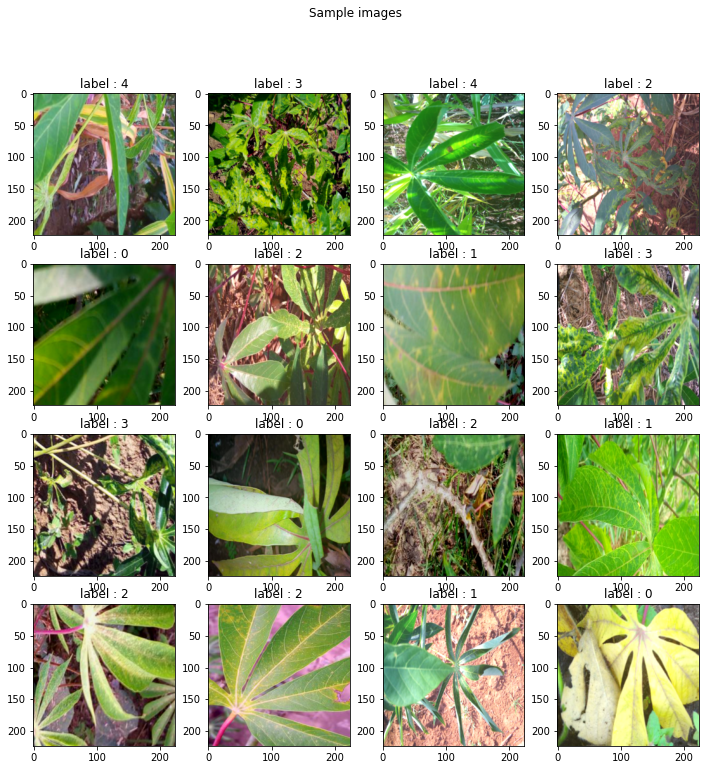

In [10]:
(sample_batch, sample_label) = next(iter(train_loader))

is_norm = False

fig = plt.figure(figsize=(12, 12))
for i in range(4):
    for j in range(4):
        fig.add_subplot(4, 4, (i * 4 + j + 1))
        if is_norm:
            plt.imshow((sample_batch[i*4+j].permute(1,2,0) * 255).astype(np.uint8))
        else:
            plt.imshow(sample_batch[i*4+j].permute(1, 2, 0))
        plt.title(f"label : {sample_label[i*4+j]}")
plt.suptitle("Sample images")

# Training Definition

In [11]:
def run_train(x, y, net, optimizer):
    x = x.to(device)
    y = y.to(device)

    optimizer.zero_grad()
    pred = net.train()(x)
    loss = F.cross_entropy(pred, y, reduction='mean')
    with torch.no_grad():
        acc = (pred.argmax(dim=-1) == y).float().mean()
    loss.backward()
    optimizer.step()

    return loss, acc
    
def run_eval(x, y, net, optimizer):
    x = x.to(device)
    y = y.to(device)

    with torch.no_grad():
        pred = net.eval()(x)
        loss = F.cross_entropy(pred, y, reduction='mean')
        acc = (pred.argmax(dim=-1) == y).float().mean()
    return loss, acc

def run_epoch(dataset, dataloader, train, net, optimizer, epoch=None, writer=None):
    total_loss = 0.0
    total_acc = 0.0
    n_data = len(dataloader) * dataloader.batch_size 
    
    pbar = tqdm(total=n_data, leave=False)
    
    mode = 'Train' if train else 'Test'
    epoch_str = '' if epoch is None else '[Epoch {}/{}]'.format(
            str(epoch).zfill(len(str(args.n_epochs))), args.n_epochs)
    
    for i, data in enumerate(dataloader):

        loss, acc = run_train(data[0], data[1], net, optimizer) if train else \
            run_eval(data[0], data[1], net, optimizer)
        '''
        if train and writer is not None:
            assert(epoch is not None)
            step = epoch * len(dataloader) + i
            writer.add_scalar('Loss/Train', loss, step)
            writer.add_scalar('Accuracy/Train', acc, step)
        '''
        batch_size = data[0].shape[0]
        total_loss += (loss * batch_size)
        total_acc += (acc * batch_size)

        pbar.set_description('{} {} Loss: {:f}, Acc : {:.4f}%'.format(
            epoch_str, mode, loss, acc))
        pbar.update(batch_size)


    mean_loss = total_loss / float(n_data)
    mean_acc = total_acc / float(n_data)
    return mean_loss, mean_acc

def run_epoch_train_and_test(
    train_dataset, train_dataloader, test_dataset, test_dataloader, net, 
    optimizer, args, epoch=None, writer=None):
    train_loss, train_acc = run_epoch(
        train_dataset, train_dataloader, train=args.train, net=net, optimizer=optimizer, epoch=epoch, writer=None)
    test_loss, test_acc = run_epoch(
        test_dataset, test_dataloader, train=False, net=net, optimizer=optimizer, epoch=epoch, writer=None)

    if writer is not None:

        assert(epoch is not None)
        step = (epoch + 1) * len(train_dataloader)
        writer.add_scalar('Loss/Train', train_loss, step)
        writer.add_scalar('Accuracy/Train', train_acc, step)

        writer.add_scalar('Loss/Test', test_loss, step)
        writer.add_scalar('Accuracy/Test', test_acc, step)

    epoch_str = '' if epoch is None else '[Epoch {}/{}]'.format(
            str(epoch).zfill(len(str(args.n_epochs))), args.n_epochs)

    log = epoch_str + ' '
    log += 'Train Loss: {:f}, '.format(train_loss)
    log += 'Train Acc: {:.4f}%, '.format(train_acc)
    log += 'Test Loss: {:f}, '.format(test_loss)
    log += 'Test Acc: {:.4f}%.'.format(test_acc)
    print(log)
    return test_loss, test_acc
    
def train_model(args, train_dataset, train_dataloader, test_dataset, 
                test_dataloader, net):
    if args.optimizer == 'adam':
        optimizer = torch.optim.Adam(
            net.parameters(), lr=args.learning_rate,
            betas=(args.beta1, args.beta2))
    elif args.optimizer == 'sgd':
        optimizer = torch.optim.SGD(
            net.parameters(), lr=args.learning_rate, momentum=args.momentum, 
            weight_decay=args.weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, step_size=args.step_size, gamma=args.gamma)

    print(args)
    print()
    if torch.cuda.is_available():
        net.to(device)

    if args.model != '':
        print(args.model, "Loaded")
        net.load_state_dict(torch.load(args.model))

    args.out_dir = args.out_dir + '{}_{}_lr{}'.format(args.name, args.optimizer, args.learning_rate)
    if not os.path.exists(args.out_dir):
        os.makedirs(args.out_dir)
    
    if args.train:
        writer = SummaryWriter(args.out_dir)
        %load_ext tensorboard
        %tensorboard --logdir={args.out_dir} --port 9999
        best_acc = 0.0
        for epoch in range(args.n_epochs):
            test_loss, test_acc = run_epoch_train_and_test(train_dataset, 
                train_dataloader, test_dataset, test_dataloader, net, 
                optimizer, args, epoch, writer)

            if test_acc > best_acc:
                best_acc = test_acc

                model_file = os.path.join(
                    args.out_dir, '{}_epoch{:d}.pt'.format(args.name, epoch + 1))
                torch.save(net.state_dict(), model_file)
                print("Saved '{}'.".format(model_file))

            scheduler.step()
        print("Best accuracy: %f"%(best_acc))
        writer.close()
    else:
        run_epoch_train_and_test(train_dataset, train_dataloader, test_dataset, test_dataloader)

# Model Definition

In [12]:
net = torchvision.models.resnet50(pretrained = False)

# Train

In [13]:
#train_model(args, train_dataset, train_loader, valid_dataset, valid_loader, net)

In [14]:
args.out_dir = args.out_dir + '/{}_{}_lr{}'.format(args.name, args.optimizer, args.learning_rate)

In [15]:
np.save(args.out_dir + '/valid_idx.npy', valid_idx.numpy())

In [16]:
valid_idx = np.load(args.out_dir + '/valid_idx.npy')
## load model ##
best_model = torch.load(glob.glob(args.out_dir  + "/*.pt")[-1])

net.load_state_dict(best_model)
net.eval()

pred_dataset = cassava_dataset(root=train_path, csv=csv,
                               train_test="train",
                               idx=valid_idx,
                               transform=test_transform)
pred_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=args.batch_size,
                                           shuffle=False,
                                           num_workers=args.n_workers,
                                           drop_last=True
                                           )

In [17]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    all_labels = torch.tensor([])
    all_preds = all_preds.to(device)
    all_labels = all_labels.to(device)
    for images, labels in loader:
        images = images.float().to(device)
        labels = labels.to(device)
        preds = model(images)
        all_preds = torch.cat((all_preds, preds), dim=0)
        all_labels = torch.cat((all_labels, labels), dim=0)
    return all_preds, all_labels

def get_num_correct(preds, labels):
    # acc = (preds.argmax(dim=-1) == labels).float().mean()
    return preds.argmax(dim=-1).eq(labels).sum().item()

net = net.to(device)
preds, labels = get_all_preds(net, pred_loader)

preds_correct = get_num_correct(preds, labels)



In [18]:
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.         0.         0.         0.98522167 0.01477833]
 [0.         0.         0.         0.97744361 0.02255639]
 [0.         0.         0.         0.98390805 0.01609195]
 [0.         0.         0.         0.98439938 0.01560062]
 [0.         0.         0.         0.96767677 0.03232323]]


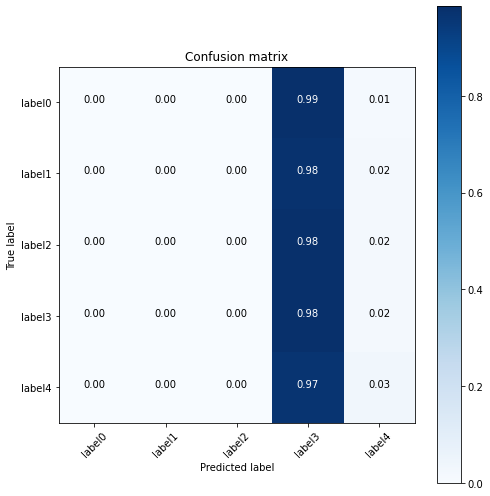

In [19]:
labels = labels.to('cpu')
preds = preds.to('cpu')
cm = confusion_matrix(labels, preds.argmax(dim=1))
plt.figure(figsize=(7, 7))
plot_confusion_matrix(cm, ['label0', 'label1', 'label2', 'label3', 'label4'], normalize=True)
plt.savefig(args.out_dir + '/confusion_matrix.png')